In [1]:
global ROOT_DIR
ROOT_DIR = '/gpfs/commons/groups/gursoy_lab/aelhussein/ot_cost/otcost_fl_rebase'
DATA_DIR = f'{ROOT_DIR}/data/Synthetic'
import pandas as pd
import numpy as np
import sympy as sym
from sklearn.preprocessing import normalize
import ot
import sys
sys.path.append(f'{ROOT_DIR}/code/helper/')
sys.path.append(f'{ROOT_DIR}/code/Synthetic/')
import OTCost as ot
import importlib
importlib.reload(ot)
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import pickle

In [13]:
d = 1e3
n = 1e3
beta = 0.01
rho = 0.1

v1 = 2*np.sqrt(d*np.log(n/beta))
v2 = 2*np.log(n/beta)

(np.sqrt(2)/n)*(d+v1+v2), (np.sqrt(2)/n)*(d)

(1.7502624589204274, 1.4142135623730951)

In [20]:
d = 1800
n = 1800
3*np.sqrt(2*d**3)/(n*d)

0.1

In [2]:
def loadData(data_num, cost):
    ##load data
    X = pd.read_csv(f'{DATA_DIR}/data_{data_num}_{cost:.2f}.csv', sep = ' ', names = [i for i in range(13)])
    X = X.sample(800)
    y = X.iloc[:,-1]
    X = X.iloc[:,:-1]
    return X.values, y.values

In [6]:
def comapre_label_costs_private(cost):
    """ Compare cost of true and dp mechanism """
    X1, y1 = loadData(1, cost)
    X2, y2 = loadData(2, cost)
    data = {'1':X1, '2':X2}
    label = {'1':y1, '2':y2}
    label_perm = list(product(set(label['1']), set(label['2']), repeat = 1))
    results = {}
    for i in label_perm:
        runs = 1000
        true_median = np.zeros(runs)
        dp_median = np.zeros(runs)
        for k in range(runs):
            index_1 = np.argwhere(label['1'] == i[0]).reshape(1,-1)[0]
            index_2 = np.argwhere(label['2'] == i[1]).reshape(1,-1)[0] 
            part_X1 = data['1'][index_1]
            part_X2 = data['2'][index_2]

            label_cost_true = None
            while label_cost_true is None:
                compressed_X1, compressed_X2 = ot.compress_vector(i, part_X1, part_X2)
                mu_1, sigma_1 = ot.get_normal_params(compressed_X1)
                mu_2, sigma_2 = ot.get_normal_params(compressed_X2)
                label_cost_true = ot.hellinger_distance(mu_1, sigma_1, mu_2, sigma_2)
                true_median[k] = label_cost_true

            label_cost_dp = None
            while label_cost_dp is None:
                mu_1, sigma_1 = ot.get_normal_params(compressed_X1, private = True)
                mu_2, sigma_2 = ot.get_normal_params(compressed_X2, private = True)
                label_cost_dp = ot.hellinger_distance(mu_1, sigma_1, mu_2, sigma_2)
                dp_median[k] = label_cost_dp
        
        results[i] = [np.median(label_cost_true), np.median(label_cost_dp)]
    return results

In [7]:
importlib.reload(ot)
costs = [0.03, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
results = {}
for cost in costs:
    results[cost] = comapre_label_costs_private(cost)
with open(f'{ROOT_DIR}/results/privacy/accuracy_dp_labels.pkl', 'wb') as f:
    pickle.dump(results, f)

Degenerate vector, reducing dimension
Degenerate vector, reducing dimension
Degenerate vector, reducing dimension
Degenerate vector, reducing dimension
Degenerate vector, reducing dimension
Degenerate vector, reducing dimension
Degenerate vector, reducing dimension
Degenerate vector, reducing dimension
Degenerate vector, reducing dimension
Degenerate vector, reducing dimension
Degenerate vector, reducing dimension
Degenerate vector, reducing dimension
Degenerate vector, reducing dimension
Degenerate vector, reducing dimension
Degenerate vector, reducing dimension
Degenerate vector, reducing dimension
Degenerate vector, reducing dimension
Degenerate vector, reducing dimension
Degenerate vector, reducing dimension
Degenerate vector, reducing dimension
Degenerate vector, reducing dimension
Degenerate vector, reducing dimension
Degenerate vector, reducing dimension
Degenerate vector, reducing dimension
Degenerate vector, reducing dimension
Degenerate vector, reducing dimension
Degenerate v

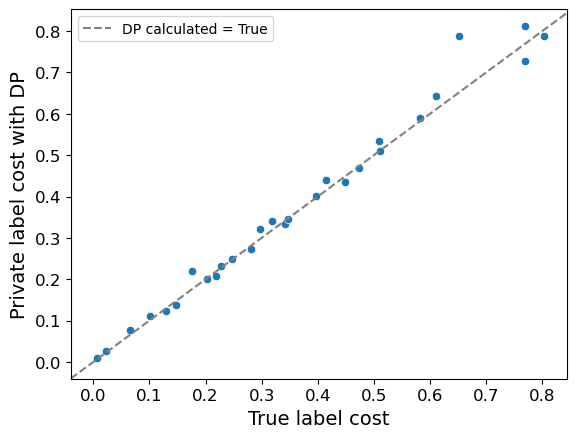

In [8]:
scores = []
for cost, label_scores in  results.items():
    for labels, score_pair in label_scores.items():
        scores.append(score_pair)
scores = pd.DataFrame(scores, columns = ['True', 'DP'])
sns.scatterplot(x=scores['True'], y = scores['DP'])
plt.axline((0, 0), slope=1, color='grey', linestyle='--', label = 'DP calculated = True')
plt.xlabel('True label cost', fontsize = 14)
plt.ylabel('Private label cost with DP', fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend()
plt.savefig(f'{ROOT_DIR}/results/privacy/accuracy_dp_labels.pdf')
plt.show()